In [1]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import cv2
from pathlib import Path

In [2]:
paths = ["train/image", "test/image"] 
images = []  # Lista para almacenar las imágenes

for path in paths:
    imgs = Path(path).glob("**/*.png") 
    imgs = [str(x) for x in imgs]
    for img in imgs: 
        imagen = cv2.imread(img,1)
        imagen = cv2.resize(imagen, (160, 160), cv2.INTER_AREA)
        imagen = imagen / 255
        images.append(imagen)

images = np.array(images)
print(f"Mask images shape: {images.shape}")
    

Mask images shape: (100, 160, 160, 3)


In [3]:
paths = ["train/mask", "test/mask"] 
masks = []  # Lista para almacenar las imágenes

for path in paths:
    imgs = Path(path).glob("**/*.png") 
    imgs = [str(x) for x in imgs]
    for img in imgs: 
        imagen = cv2.imread(img,0)
        imagen = cv2.resize(imagen, (160, 160), cv2.INTER_AREA)
        imagen = imagen / 255
        masks.append(imagen)
masks = np.array(masks, dtype = np.uint8)
masks =  np.expand_dims(masks, axis = -1)
masks = np.array(masks)
print(f"Images shape: {masks.shape}")
    

Images shape: (100, 160, 160, 1)


In [4]:
def get_model(img_size=(160,160,3), num_clases = 1) :
    inputs = keras.Input(shape=img_size)
    #Primera mitas de la red: Extracción de las características

    #Bloque de entrada
    x =  keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    #Parte residual
    previous_block = x

    #Bloques de convoluciEl bloque 1, 2 y 3 son iguales
    for filters in [64, 128, 256] : 
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Projección residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block)
        x = keras.layers.add([x, residual])
        previous_block = x

    #Segunda mitad
    for filters in [256, 128, 64, 32] : 
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)
        
        # Projección residual
        residual = keras.layers.UpSampling2D(2)(previous_block)
        residual = keras.layers.Conv2D(filters, 1, padding = "Same")(residual)
        x = keras.layers.add([x, residual])
        previous_block = x
    
    outputs = keras.layers.Conv2D(num_clases, 3, activation = "sigmoid", padding = "same")(x)
    
    # Definir el modelo
    model = keras.Model(inputs, outputs)
    return model

model = get_model()
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,401 (7.85 MB)

 Trainable params: 2,054,625 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

None


In [5]:
model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam())
history = model.fit(images, masks, epochs=100, batch_size=8)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - loss: 0.9873
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - loss: 0.2178
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - loss: 0.1491
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - loss: 0.1218
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 0.1137
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - loss: 0.1126
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - loss: 0.1097
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - loss: 0.1099
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - loss: 0.1098
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - loss: 0.1103
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - loss: 0.1099
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - loss: 0.1052
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - loss: 0.1079
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.1085
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


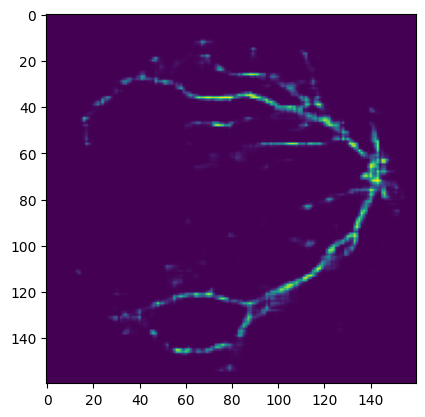

In [6]:
from matplotlib import pyplot as plt
test_image = images[1]
test_image = np.expand_dims(test_image, axis = 0)
out_image = model.predict(test_image)
out_image = np.squeeze(out_image)
plt.imshow(out_image)
